In [1]:
import logreg
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/bank.csv', sep=';')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [3]:
# get targets
y = data.y.apply(lambda x: 0 if x == 'no' else 1)
data = data.drop('y', axis=1)

In [4]:
# candidates for integer encoding (ordinal variables):
to_label = ['education', 'month', 'housing']

# candidates for one-hot encoding (nominal variables):
to_onehot = ['job', 'loan', 'marital', 'contact', 'poutcome', 'default']

# scikit-learn label encoder
le = LabelEncoder()

# get dummy and label encodings
dummies = pd.get_dummies(data[to_onehot])
labels = data[to_label].apply(le.fit_transform)

# Convert dataframe to dummy and label encodings
data[to_label] = labels
data = pd.concat([data, dummies], axis=1)
data = data.drop(to_onehot, axis=1)

In [5]:
# Get predictors and targets
X = data.to_numpy()
y = y.to_numpy()

# positive class is under represented, so oversample
oversampler = SMOTE()
smote_X, smote_y = oversampler.fit_resample(X, y)

In [6]:
# split into test/training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

Loss after 1000 epochs: 7.556909180547906
Loss after 2000 epochs: 4.710346743539169
Loss after 3000 epochs: 2.3440061343715386
Loss after 4000 epochs: 1.6143673190118861
Loss after 5000 epochs: 1.3012186065307985
Loss after 6000 epochs: 1.1700782047832166


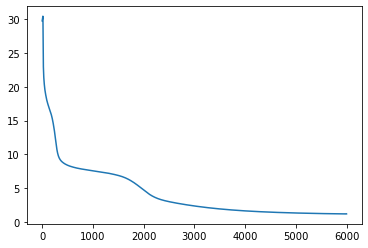

In [7]:
# create logistic regression model using all variables
regressor = logreg.BinaryLogisticRegression(X.shape[-1])

# train logistic regression model
epochs = 6000
loss = regressor.train(X_train, y_train, epochs=epochs, lr=1e-5, print_every=1000)

# plot average loss per epoch
sns.lineplot(x=range(epochs), y=loss)
plt.show()

In [8]:
y_hat = regressor.infer(X_test)
prediction = [1 if y > 0.5 else 0 for y in y_hat]

In [9]:
# accuracy: 
(y_test == prediction).mean()

0.7259668508287292